In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [25]:
df = pd.read_excel("./data/SWAT.xlsx")
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 7:50:00 AM,2.462287,541.3740,2,1,1,260.7344,8.409895,324.8398,0.000513,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
1,28/12/2015 7:50:01 AM,2.441469,541.4918,2,1,1,260.7344,8.412138,324.3015,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
2,28/12/2015 7:50:02 AM,2.428338,541.2955,2,1,1,260.7344,8.414701,323.7888,0.000256,...,2,1,251.4580,1.297536,190.1436,0.000064,1,1,1,Normal
3,28/12/2015 7:50:03 AM,2.425776,542.5124,2,1,1,260.7344,8.420149,323.3530,0.000256,...,2,1,251.4580,1.441707,190.1436,0.000064,1,1,1,Normal
4,28/12/2015 7:50:04 AM,2.424174,542.7871,2,1,1,260.7344,8.423674,322.8916,0.000256,...,2,1,251.2817,1.441707,190.1436,0.000064,1,1,1,Normal


In [26]:
df['Normal/Attack'].replace({'Normal':0, 'Attack':1}, inplace=True)
df["anomaly"] = df["Normal/Attack"]

anomaly = df.anomaly
df.drop(["Normal/Attack"], axis=1, inplace=True)

In [27]:
important_features = [
    'LIT101', 'MV301', 'MV302', ' MV303', 'MV304', 'P302', 'AIT401', 'AIT504', 'FIT504', 'PIT502', 'P602', 'anomaly']

In [28]:
df = df[important_features]
df.head()

,LIT101,MV301,MV302,MV303,MV304,P302,AIT401,AIT504,FIT504,PIT502,P602,anomaly
0,541.3740,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1,0
1,541.4918,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1,0
2,541.2955,1,1,1,1,1,148.808,12.03538,0.306761,1.297536,1,0
3,542.5124,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1,0
4,542.7871,1,1,1,1,1,148.808,12.03538,0.306761,1.441707,1,0


In [29]:
first_anomaly_index = anomaly[anomaly == 1].index[0]
train_size = int(first_anomaly_index * 0.8)

### Autoencoder prediction

In [30]:
from sklearn.ensemble import IsolationForest
from ipywidgets import IntProgress
from IPython.display import display

In [31]:
from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler

In [42]:
from utils.pipeline import Pipeline, Predictor

class Config:
    n_estimators = 100
    contamination = 0.05
    
conf = Config
conf.train_size = train_size

class LSTM_AE_2ndPredictor:
    def fit(self, df_train):
        x_train = df_train[:train_size].drop(["anomaly"], axis=1)


        self.model = IsolationForest(n_estimators=conf.n_estimators,
                              contamination=conf.contamination, 
                              n_jobs=-1, random_state=seed_value)
        
        self.model.fit(x_train.values)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df[important_features]
            df.drop(["anomaly"], axis=1, inplace=True)
            prediction_raw = self.model.predict(df.values)
            prediction = pd.Series(prediction_raw, df.index).map({-1: 1, 1:0})
            
            pr = pd.Series(prediction_raw, df.index).map({-1: 1, 1:0})
        
            smoothed = pr.rolling(window = 10).mean().fillna(pr.iloc[0])

            prediction = smoothed > 0.6
            
            predictions[file_name] = prediction
            
        return predictions

In [43]:
df[:train_size].shape

(10090, 12)

In [44]:
df_by_names['swat'].shape

(8573, 12)

In [45]:
%%time
predictor = LSTM_AE_2ndPredictor()
predictor.fit(df[:train_size])

CPU times: total: 625 ms
Wall time: 621 ms


In [46]:
%%time
df_by_names = {"swat": df[train_size:]}
y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = predictor.predict(df_by_names)

CPU times: total: 281 ms
Wall time: 314 ms


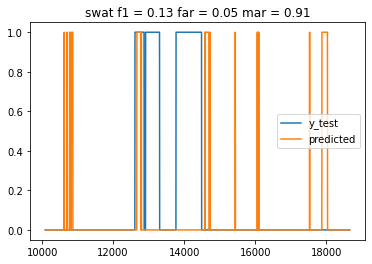

In [47]:
from utils.metrics import f1_score, far, mar
metrics= {}
predictions = []

draw = 1

all_prediction = {"swat": []}
all_test = {"swat": []}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    all_prediction["swat"].append(prediction)
    all_test["swat"].append(prediction)
            
    metrics[file_name] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

In [48]:
from utils.data import show_score_table

show_score_table(metrics)

metric | swat
--- | ---
F1 |0.13
FAR |0.05
MAR |0.91

### SKAB

In [52]:
from utils.pipeline import Pipeline, Predictor
from tensorflow import keras

from utils.pipeline import Pipeline, Predictor
class Config:
    contamination = 0.01
    
conf = Config

class IForestSKABPredictor:
    def fit(self, df_train):
        x_train = df_train[:train_size].drop(["anomaly"], axis=1)
        self.model = IsolationForest(contamination=conf.contamination, 
                              n_jobs=-1, random_state=seed_value)
        
        self.model.fit(x_train.values)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df[important_features]
            df.drop(["anomaly"], axis=1, inplace=True)
            
            prediction_raw = self.model.predict(df.values)
            prediction = pd.Series(self.model.predict(df)*-1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1,0)
            
            predictions[file_name] = prediction
            
        return predictions
    
    

In [53]:
%%time
skab_predictor = IForestSKABPredictor()
skab_predictor.fit(df[:train_size])

CPU times: total: 625 ms
Wall time: 604 ms


In [54]:
%%time
predictions_by_names = skab_predictor.predict(df_by_names)

CPU times: total: 578 ms
Wall time: 588 ms


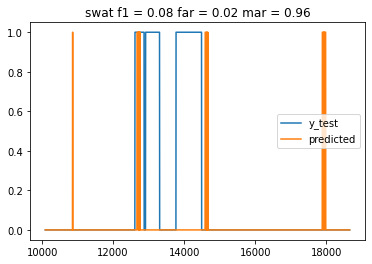

In [55]:
from utils.metrics import f1_score, far, mar
metrics= {}
predictions = []

draw = 1

all_prediction = {"swat": []}
all_test = {"swat": []}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    all_prediction["swat"].append(prediction)
    all_test["swat"].append(prediction)
            
    metrics[file_name] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

In [58]:
from utils.data import show_score_table

show_score_table(metrics)

metric | swat
--- | ---
F1 |0.4
FAR |0.26
MAR |0.42